# Loyalty Clustering


In [130]:
# Jupyter notebook: optional formatting extension
# %load_ext nb_black

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import datetime
import math
from math import ceil

# Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer

# Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor

# Clustering evaluation
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score

# Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Stats
from scipy.stats import chi2_contingency, stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.mosaicplot import mosaic

# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Model selection
from sklearn.model_selection import GridSearchCV

# Geospatial
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import geopandas as gpd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
import matplotlib.cm as cm


In [131]:
loyalty_clustering = pd.read_csv("df_ready_for_clustering.csv")
loyalty_clustering.head()


,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,LoyaltyIndex,CustomerSegment,HasBonus,AvgMonthlyFlights,sr_jan,...,Education,Income,Marital Status,LoyaltyStatus,EnrollmentMonth,Time on Program,Cancelled,Reenroll,EnrollmentType,Customer Lifetime Value
0,0.387904,0.200000,2356.577778,25.786888,32446,709.589704,Moderate traveler and high redeemed,0,6.250000,0.026667,...,Bachelor,82877.0,Married,Aurora,8,874,N,0,Standard,7919.20
1,0.553363,0.224490,1384.141224,18.077435,15141,418.130598,Low traveler and low redeemed,0,6.805556,0.077551,...,College,0.0,Single,Nova,3,2122,N,0,Standard,2887.74
2,0.113362,0.241706,2047.539336,88.241585,38293,616.640254,Moderate traveler and low redeemed,0,5.861111,0.094787,...,College,0.0,Divorced,Nova,7,884,N,0,Standard,2838.07
3,0.354092,0.157407,3375.941667,28.248369,23544,1014.088728,High traveler and high redeemed,0,3.000000,0.000000,...,Bachelor,42837.0,Married,Star,8,1242,N,0,Standard,4170.57
4,0.253580,0.276243,2373.649171,39.448214,32058,714.181936,Moderate traveler and high redeemed,0,5.027778,0.022099,...,Bachelor,80979.0,Divorced,Star,1,1816,N,0,Standard,6622.05


In [132]:
features = ['Time on Program',  'EnrollmentMonth']
loyalty_clustering = loyalty_clustering[features]
loyalty_clustering.head()

,Time on Program,EnrollmentMonth
0,874,8
1,2122,3
2,884,7
3,1242,8
4,1816,1


We will not do anything to the outliers, since when using DBSCAN we have 95% of noise, so we will just standardized.

In [133]:
# Cell 7: Remove outliers using DBSCAN
#from collections import Counter
#dbscan = DBSCAN(eps=2.0, min_samples=20, n_jobs=4)
#dbscan_labels = dbscan.fit_predict(loyalty_clustering)

# Check outlier count
#outlier_count = Counter(dbscan_labels)
#print(f"DBSCAN results: {outlier_count}")
#print(f"Outliers detected: {outlier_count[-1]}")
#print(f"Core customers: {outlier_count[0]}")

# Save outliers for later classification
#df_out = loyalty_clustering[dbscan_labels == -1].copy()

# Filter to core customers only
#df = loyalty_clustering[dbscan_labels != -1].copy()
#print(f"\nWorking with {len(df):,} core customers")
#print(f"Outliers saved for later: {len(df_out)}")

In [134]:
# Normalize numerical columns
numerical_columns = loyalty_clustering.select_dtypes(include=['int64', 'float64']).columns.tolist()
scaler = MinMaxScaler()
loyalty_clustering[numerical_columns] = scaler.fit_transform(loyalty_clustering[numerical_columns])
loyalty_clustering.head()

,Time on Program,EnrollmentMonth
0,0.354564,0.636364
1,0.860852,0.181818
2,0.358621,0.545455
3,0.503854,0.636364
4,0.736714,0.000000


## Hierarchical Clustering

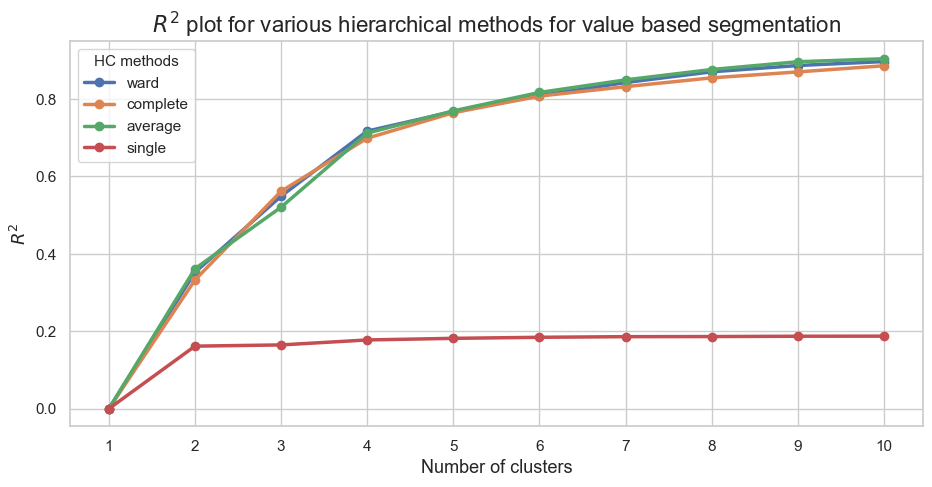

In [135]:

def get_ss(df, feats):
    """Compute total sum of squares (SST) for features in df."""
    X = df[feats].values
    mean_vec = X.mean(axis=0)
    return ((X - mean_vec)**2).sum()

def get_ssw(df, feats, label_col):
    """Compute sum of squares within clusters (SSW)."""
    X = df[feats].values
    labels = df[label_col].values
    ssw = 0
    for lbl in np.unique(labels):
        cluster_points = X[labels == lbl]
        cluster_mean = cluster_points.mean(axis=0)
        ssw += ((cluster_points - cluster_mean)**2).sum()
    return ssw

def get_rsq(df, feats, label_col):
    """Compute R² for clustering solution."""
    sst = get_ss(df, feats)
    ssw = get_ssw(df, feats, label_col)
    ssb = sst - ssw
    return ssb / sst


def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """Compute R² for a range of cluster solutions."""
    r2 = []
    feats = df.columns.tolist()
    
    for i in range(min_nclus, max_nclus + 1):
        cluster = AgglomerativeClustering(
            n_clusters=i,
            metric=dist,
            linkage=link_method
        )
        hclabels = cluster.fit_predict(df[feats])
        df_concat = pd.concat([df, pd.Series(hclabels, name='labels', index=df.index)], axis=1)
        r2.append(get_rsq(df_concat, feats, 'labels'))
    
    return np.array(r2)


metric_features = loyalty_clustering.columns.tolist()  # your numeric features for clustering
hc_methods = ["ward", "complete", "average", "single"]
max_nclus = 10

results = []

for link in hc_methods:
    r2 = get_r2_hc(
        df=loyalty_clustering[metric_features],
        link_method=link,
        max_nclus=max_nclus,
        min_nclus=1,
        dist="euclidean"
    )
    results.append(r2)

r2_hc = np.vstack(results)


sns.set(style="whitegrid")
plt.figure(figsize=(11,5))

for i, link in enumerate(hc_methods):
    plt.plot(range(1, max_nclus + 1), r2_hc[i], marker='o', linewidth=2.5, label=link)

plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("$R^2$", fontsize=13)
plt.xticks(range(1, max_nclus + 1))
plt.title("$R^2$ plot for various hierarchical methods for value based segmentation", fontsize=16)
plt.legend(title="HC methods", title_fontsize=11)
plt.show()



In [136]:
from scipy.cluster.hierarchy import linkage
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
distance = 'euclidean' 
n_clusters = None 

linkage_matrix= linkage(loyalty_clustering, method="ward") 

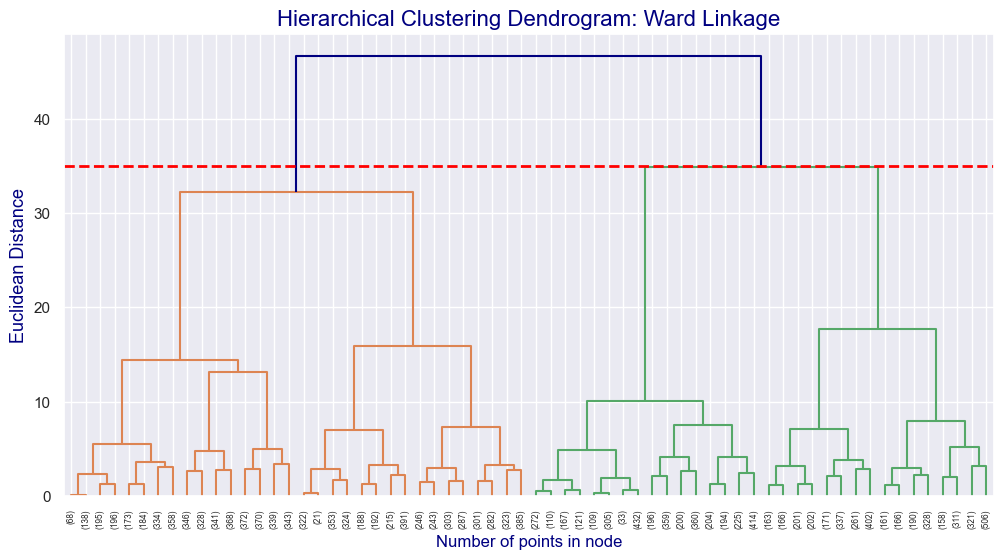

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram

sns.set()
fig = plt.figure(figsize=(12, 6))

Y_THRESHOLD = 35  # adjust based on your dendrogram

dendrogram(
    linkage_matrix,
    truncate_mode='level',
    p=5,
    color_threshold=Y_THRESHOLD,
    above_threshold_color='navy'
)

# Draw horizontal cut line across the dendrogram
plt.axhline(y=Y_THRESHOLD, color='red', linestyle='--', linewidth=2)

plt.title('Hierarchical Clustering Dendrogram: Ward Linkage', fontsize=16, color='navy')
plt.xlabel('Number of points in node', color='navy')
plt.ylabel('Euclidean Distance', fontsize=13, color='navy')
plt.show()


Lets try 3,4,5 and 6 clusters

In [138]:
# Test with nclusters=3
hc = AgglomerativeClustering(
    n_clusters=3,
    metric='euclidean',
    linkage='ward'
)
hc_labels3 = hc.fit_predict(loyalty_clustering)

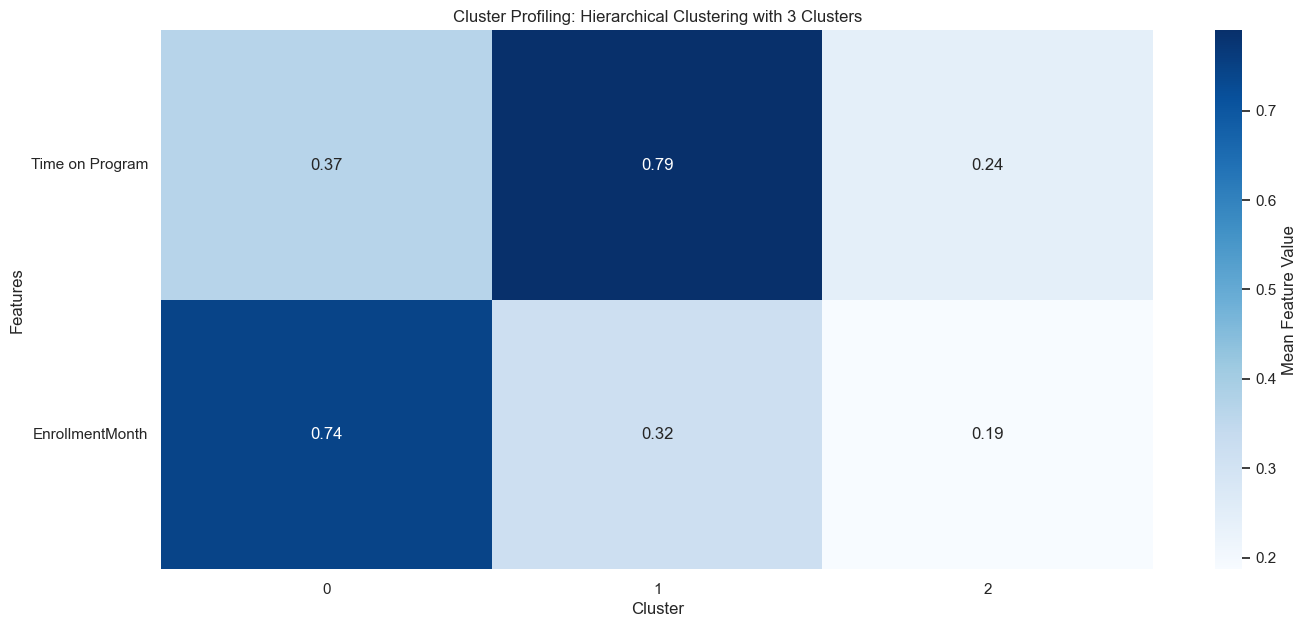

In [139]:
X = loyalty_clustering.copy()
X['labels'] = hc_labels3

cluster_means = X.groupby('labels')[loyalty_clustering.columns].mean().T

plt.figure(figsize=(16,7))
sns.heatmap(
    cluster_means,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Mean Feature Value'}
)
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.title("Cluster Profiling: Hierarchical Clustering with 3 Clusters")
plt.yticks(rotation=0)
plt.show()


In [140]:
# Test with nclusters=4
hc = AgglomerativeClustering(
    n_clusters=4,
    metric='euclidean',
    linkage='ward'
)
hc_labels4 = hc.fit_predict(loyalty_clustering)


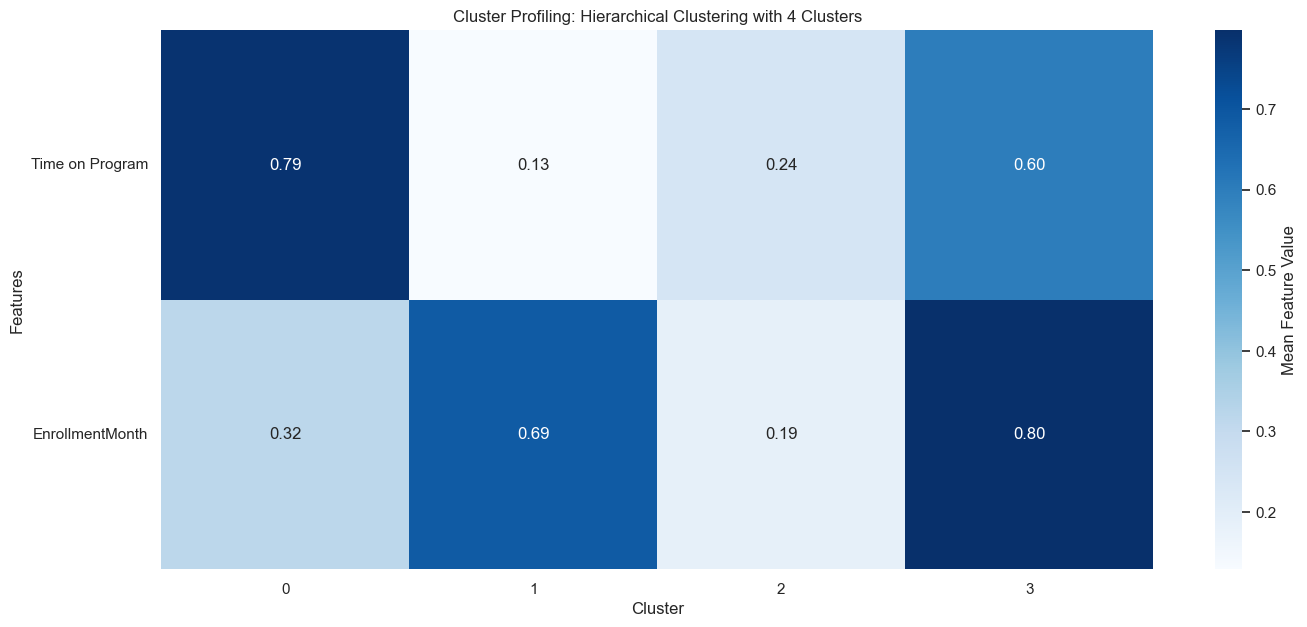

In [141]:
X = loyalty_clustering.copy()
X['labels'] = hc_labels4

cluster_means = X.groupby('labels')[loyalty_clustering.columns].mean().T

plt.figure(figsize=(16,7))
sns.heatmap(
    cluster_means,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Mean Feature Value'}
)
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.title("Cluster Profiling: Hierarchical Clustering with 4 Clusters")
plt.yticks(rotation=0)
plt.show()


In [142]:
# Now do the same but for nclusters=4
hc = AgglomerativeClustering(
    n_clusters=5,
    metric='euclidean',
    linkage='ward'
)
hc_labels5 = hc.fit_predict(loyalty_clustering)


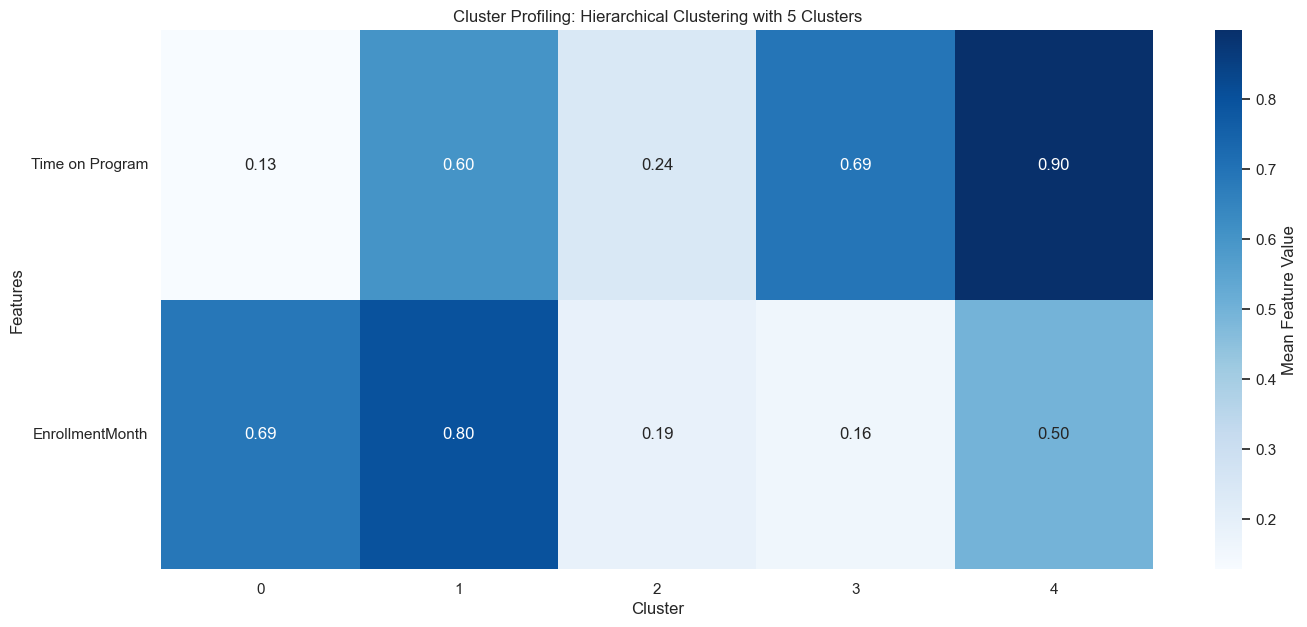

In [143]:
X = loyalty_clustering.copy()
X['labels'] = hc_labels5

cluster_means = X.groupby('labels')[loyalty_clustering.columns].mean().T

plt.figure(figsize=(16,7))
sns.heatmap(
    cluster_means,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Mean Feature Value'}
)
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.title("Cluster Profiling: Hierarchical Clustering with 5 Clusters")
plt.yticks(rotation=0)
plt.show()


In [144]:
# Now nclusters=5
hc = AgglomerativeClustering(
    n_clusters=6,
    metric='euclidean',
    linkage='ward'
)
hc_labels6 = hc.fit_predict(loyalty_clustering)


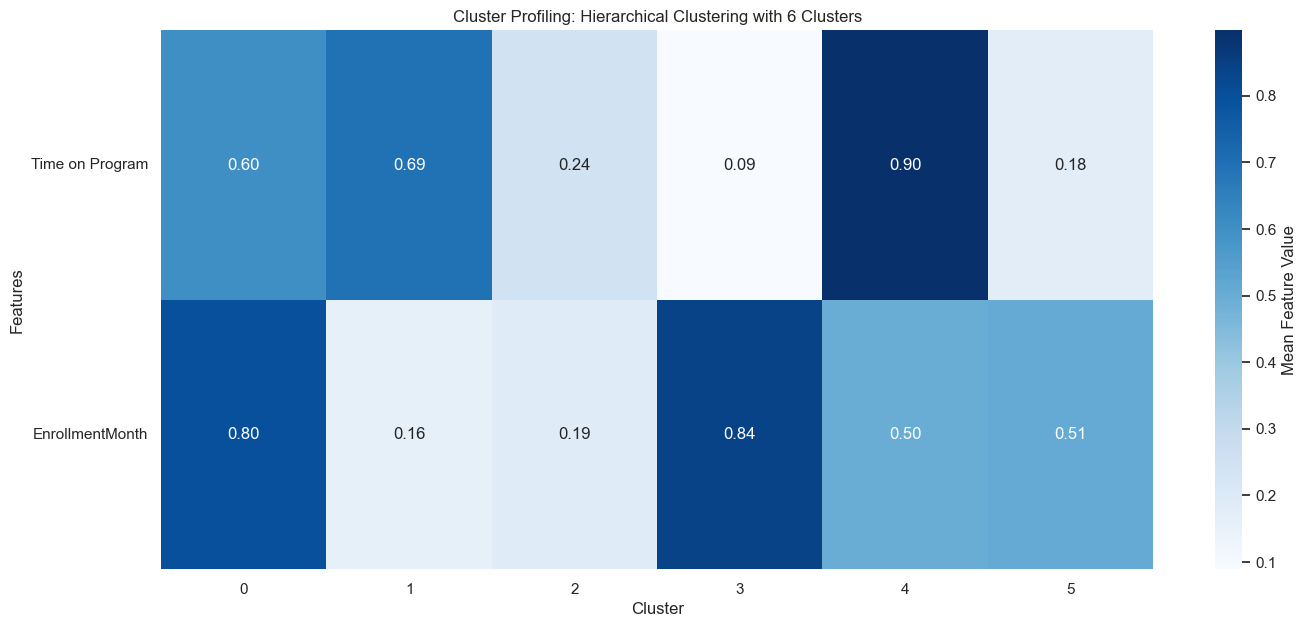

In [145]:
X = loyalty_clustering.copy()
X['labels'] = hc_labels6

cluster_means = X.groupby('labels')[loyalty_clustering.columns].mean().T

plt.figure(figsize=(16,7))
sns.heatmap(
    cluster_means,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Mean Feature Value'}
)
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.title("Cluster Profiling: Hierarchical Clustering with 6 Clusters")
plt.yticks(rotation=0)
plt.show()


## KMEANS

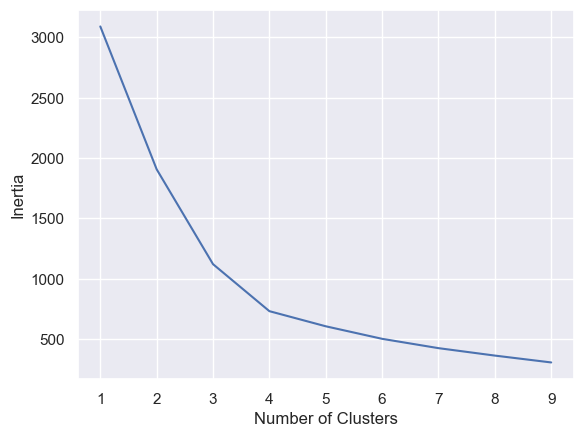

In [146]:
# Lets use the elbow method to find the best number of clusters

n_clusters = range(1, 10)
sse2 = []

for k in n_clusters:
    km = KMeans(n_clusters=k, init = "k-means++", max_iter=300, n_init=10)
    km.fit(loyalty_clustering)
    sse2.append(km.inertia_)

plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.plot(n_clusters, sse2)  
plt.show()


cluster,0,1,2,3,4
Time on Program,0.163199,0.863404,0.660339,0.658278,0.201582
EnrollmentMonth,0.773812,0.515413,0.168222,0.830249,0.247264


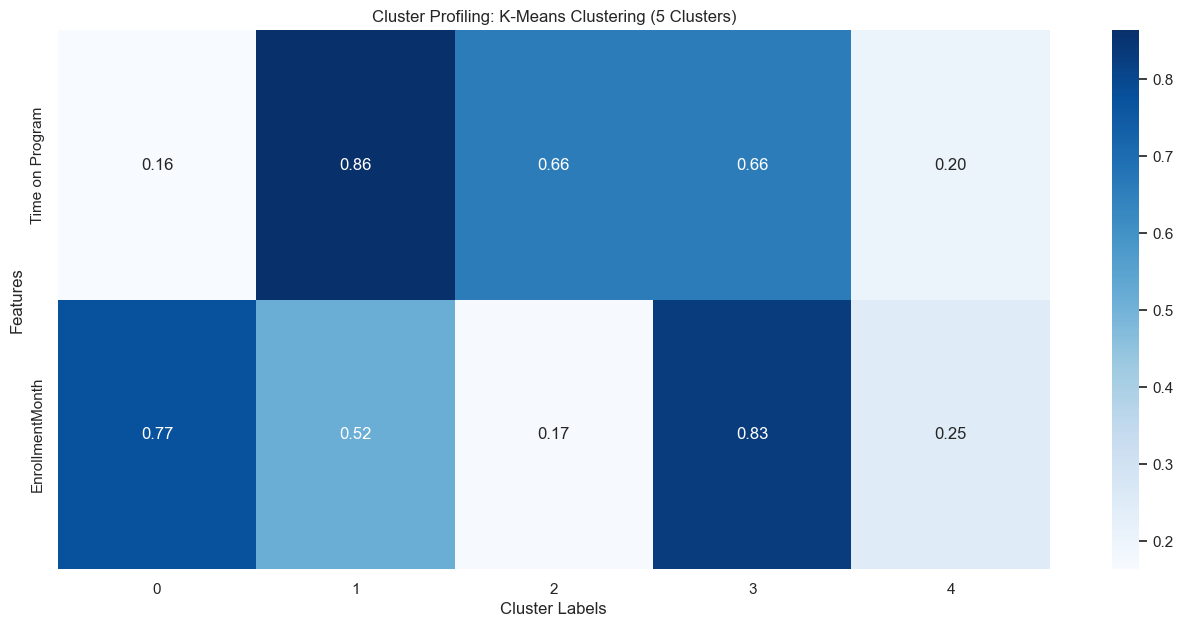

In [147]:
km = KMeans(n_clusters=5, init="k-means++", random_state=94)
km_labels_5 = km.fit_predict(loyalty_clustering)

df_value_based_with_clusters = loyalty_clustering.copy()
df_value_based_with_clusters['cluster'] = km_labels_5

cluster_profile_orig = df_value_based_with_clusters.groupby('cluster').mean()

display(cluster_profile_orig.T)

plt.figure(figsize=(16,7))
sns.heatmap(cluster_profile_orig.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: K-Means Clustering (5 Clusters)")
plt.xlabel("Cluster Labels")
plt.ylabel("Features")
plt.show()

cluster,0,1,2,3
Time on Program,0.163733,0.757412,0.219648,0.693274
EnrollmentMonth,0.774123,0.275380,0.231844,0.792504


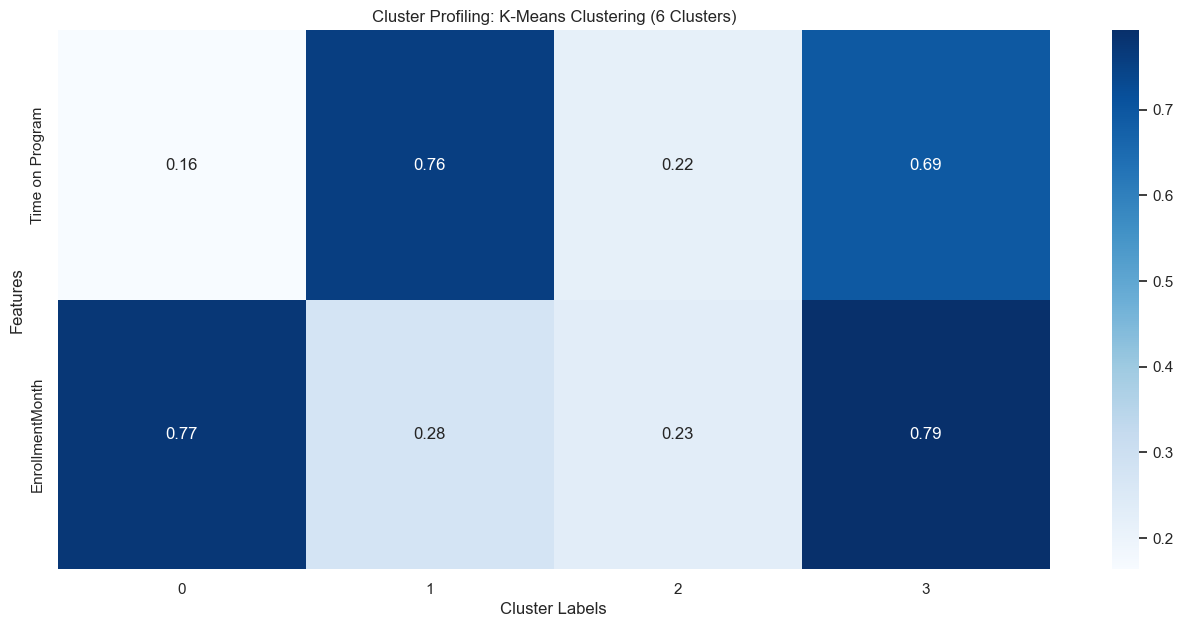

In [148]:
km = KMeans(n_clusters=4, init="k-means++", random_state=94)
km_labels_4 = km.fit_predict(loyalty_clustering)

df_value_based_with_clusters = loyalty_clustering.copy()
df_value_based_with_clusters['cluster'] = km_labels_4
cluster_profile_orig = df_value_based_with_clusters.groupby('cluster').mean()

display(cluster_profile_orig.T)

plt.figure(figsize=(16,7))
sns.heatmap(cluster_profile_orig.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: K-Means Clustering (6 Clusters)")
plt.xlabel("Cluster Labels")
plt.ylabel("Features")
plt.show()

cluster,0,1,2
Time on Program,0.193505,0.771899,0.386121
EnrollmentMonth,0.755500,0.659832,0.189396


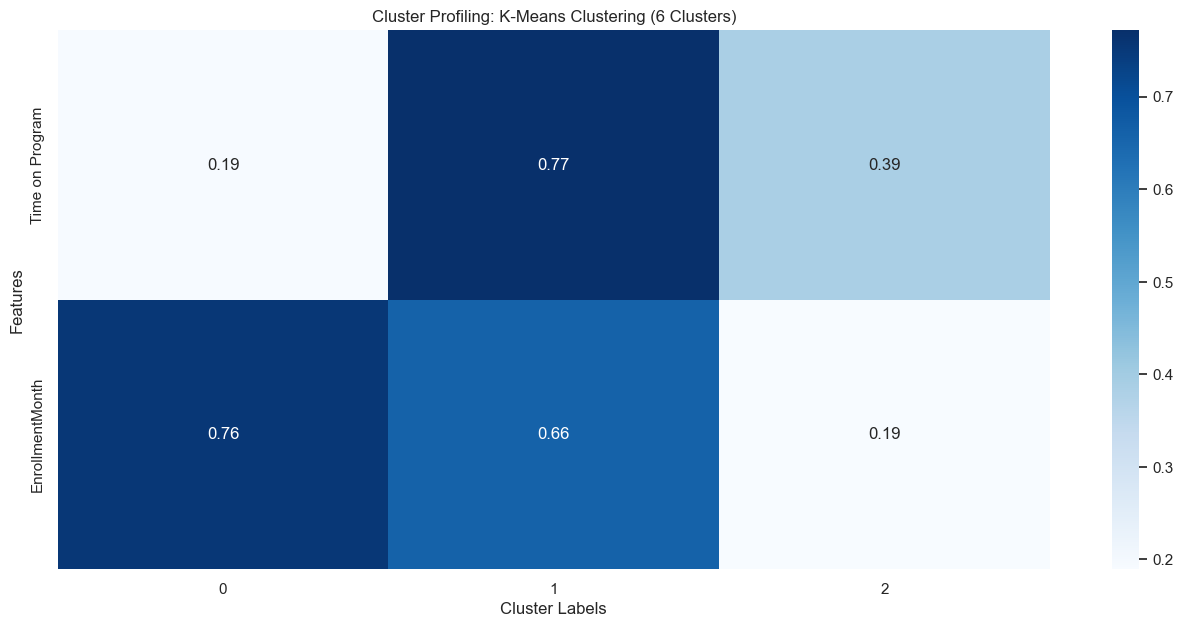

In [149]:
km = KMeans(n_clusters=3, init="k-means++", random_state=94)
km_labels_3 = km.fit_predict(loyalty_clustering)

df_value_based_with_clusters = loyalty_clustering.copy()
df_value_based_with_clusters['cluster'] = km_labels_3
cluster_profile_orig = df_value_based_with_clusters.groupby('cluster').mean()

display(cluster_profile_orig.T)

plt.figure(figsize=(16,7))
sns.heatmap(cluster_profile_orig.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: K-Means Clustering (6 Clusters)")
plt.xlabel("Cluster Labels")
plt.ylabel("Features")
plt.show()

In [150]:
# Now let's compare all results for all different methods and nclusters
X = loyalty_clustering.copy()
X['hc_3'] = hc_labels6
X['hc_4'] = hc_labels4
X['hc_5'] = hc_labels5
X['hc_6'] = hc_labels6
X['km_4'] = km_labels_4
X['km_5'] = km_labels_5
X['km_3'] = km_labels_3

# Features used for clustering
X = loyalty_clustering.copy()
# Compute metrics for KMeans with 3 clusters
kmeans_3_silhouette = silhouette_score(X, km_labels_3)
kmeans_3_calinski_harabasz = calinski_harabasz_score(X, km_labels_3)
kmeans_3_davies_bouldin = davies_bouldin_score(X, km_labels_3)
# Compute metrics for KMeans with 5 clusters
kmeans_5_silhouette = silhouette_score(X, km_labels_5)
kmeans_5_calinski_harabasz = calinski_harabasz_score(X, km_labels_5)
kmeans_5_davies_bouldin = davies_bouldin_score(X, km_labels_5)
# Compute metrics for KMeans with 4 clusters
kmeans_4_silhouette = silhouette_score(X, km_labels_4)
kmeans_4_calinski_harabasz = calinski_harabasz_score(X, km_labels_4)
kmeans_4_davies_bouldin = davies_bouldin_score(X, km_labels_4)

comparison_table = pd.DataFrame({
    "Clustering Method": ["Hierarchical (4 Clusters)", "Hierarchical (6 Clusters)", "Hierarchical (5 Clusters)","Hierarchical (3 Clusters)", "K-Means (3 Clusters)", "K-Means (5 Clusters)", "K-Means (4 Clusters)"],
    "Silhouette Score": [silhouette_score(X, hc_labels4), silhouette_score(X, hc_labels6), silhouette_score(X, hc_labels5), silhouette_score(X, hc_labels3),kmeans_3_silhouette, kmeans_5_silhouette, kmeans_4_silhouette],
    "Calinski-Harabasz Index": [calinski_harabasz_score(X, hc_labels4), calinski_harabasz_score(X, hc_labels6), calinski_harabasz_score(X, hc_labels5),calinski_harabasz_score(X, hc_labels3), kmeans_3_calinski_harabasz, kmeans_5_calinski_harabasz, kmeans_4_calinski_harabasz],
    "Davies-Bouldin Index": [davies_bouldin_score(X, hc_labels4), davies_bouldin_score(X, hc_labels6), davies_bouldin_score(X, hc_labels5), davies_bouldin_score(X, hc_labels3), kmeans_3_davies_bouldin, kmeans_5_davies_bouldin, kmeans_4_davies_bouldin]
})
comparison_table.head(6)

,Clustering Method,Silhouette Score,Calinski-Harabasz Index,Davies-Bouldin Index
0,Hierarchical (4 Clusters),0.366813,14010.168515,0.858092
1,Hierarchical (6 Clusters),0.330356,14022.862770,0.859794
2,Hierarchical (5 Clusters),0.353745,13695.296833,0.838018
3,Hierarchical (3 Clusters),0.327893,10088.634006,0.896470
4,K-Means (3 Clusters),0.409531,14561.175662,0.817762
5,K-Means (5 Clusters),0.397863,16582.507501,0.844711


### Conclusion 
    
    K-Means (3 clusters) is the optimal solution, offering clearer customer segmentation with better operational simplicity, since is the one who outperformes best in all score methods.



## GMM

cluster,0,1,2
Time on Program,0.171361,0.737184,0.382993
EnrollmentMonth,0.729100,0.675871,0.173633


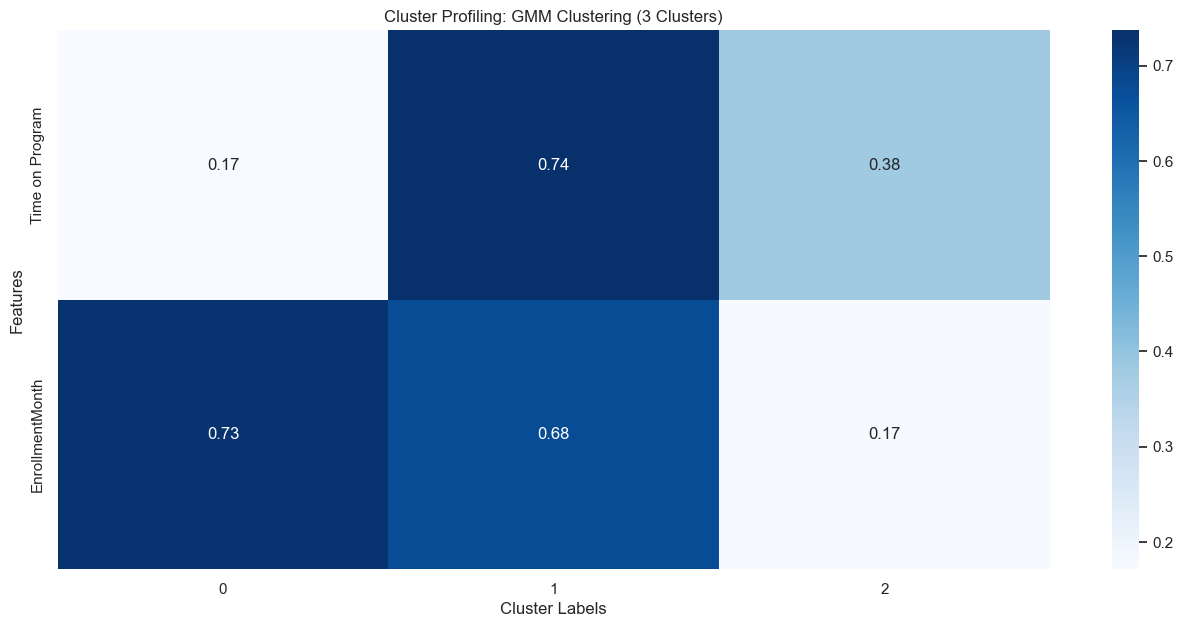

In [151]:
# Now let's try GMM
# We know that hierarchical with 4 clusters worked well
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=94)
gmm_labels_3 = gmm.fit_predict(loyalty_clustering)
df_value_based_with_clusters = loyalty_clustering.copy()
df_value_based_with_clusters['cluster'] = gmm_labels_3
cluster_profile_orig = df_value_based_with_clusters.groupby('cluster').mean()
display(cluster_profile_orig.T)
plt.figure(figsize=(16,7))
sns.heatmap(cluster_profile_orig.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: GMM Clustering (3 Clusters)")
plt.xlabel("Cluster Labels")
plt.ylabel("Features")
plt.show()



cluster,0,1,2,3
Time on Program,0.161846,0.753157,0.216599,0.690113
EnrollmentMonth,0.773567,0.273695,0.234218,0.794453


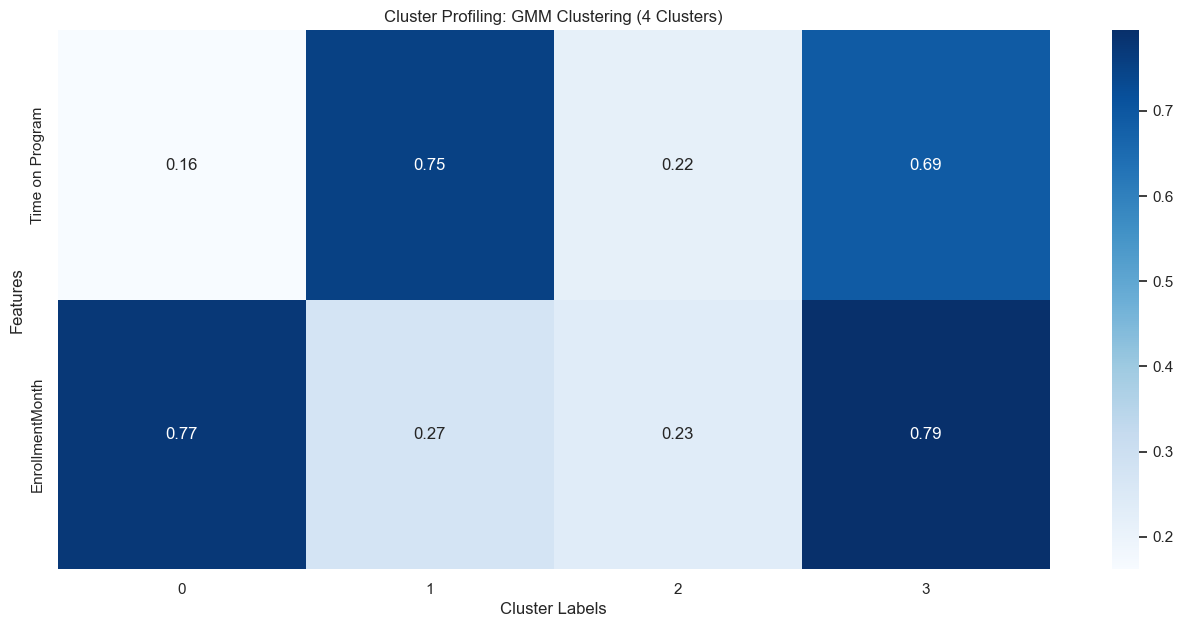

In [152]:
# Now let's try GMM
# We know that K means with 4 clusters worked well
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=94)
gmm_labels_4 = gmm.fit_predict(loyalty_clustering)
df_value_based_with_clusters = loyalty_clustering.copy()
df_value_based_with_clusters['cluster'] = gmm_labels_4
cluster_profile_orig = df_value_based_with_clusters.groupby('cluster').mean()
display(cluster_profile_orig.T)
plt.figure(figsize=(16,7))
sns.heatmap(cluster_profile_orig.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: GMM Clustering (4 Clusters)")
plt.xlabel("Cluster Labels")
plt.ylabel("Features")
plt.show()



## DBSCAN

In [153]:
# Now try DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5, n_jobs=4)
dbscan_labels = dbscan.fit_predict(loyalty_clustering)

In [154]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import DBSCAN


dbscan = DBSCAN(eps=0.5, min_samples=5, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(loyalty_clustering)


def compute_metrics(X, labels):
    # For DBSCAN, remove noise points (-1) when computing metrics
    if -1 in labels:
        mask = labels != -1
        X_valid = X[mask]
        labels_valid = labels[mask]
    else:
        X_valid = X
        labels_valid = labels

    n_clusters = len(set(labels_valid))
    if n_clusters < 2:
        return np.nan, np.nan, np.nan
    else:
        sil = silhouette_score(X_valid, labels_valid)
        ch = calinski_harabasz_score(X_valid, labels_valid)
        db = davies_bouldin_score(X_valid, labels_valid)
        return sil, ch, db


kmeans_3_silhouette, kmeans_3_calinski_harabasz, kmeans_3_davies_bouldin = compute_metrics(loyalty_clustering, km_labels_3)
gmm_4_sil, gmm_4_ch, gmm_4_db = compute_metrics(loyalty_clustering, gmm_labels_4)
gmm_3_sil, gmm_3_ch, gmm_3_db = compute_metrics(loyalty_clustering, gmm_labels_3)
dbscan_sil, dbscan_ch, dbscan_db = compute_metrics(loyalty_clustering, dbscan_labels)


comparison_table = pd.DataFrame({
    "Clustering Method": [
        "K-Means (3 Clusters)",
        "GMM (4 Clusters)",
        "GMM (3 Clusters)",
        "DBSCAN"
    ],
    "Silhouette Score": [kmeans_3_silhouette, gmm_4_sil, gmm_3_sil, dbscan_sil],
    "Calinski-Harabasz Index": [kmeans_3_calinski_harabasz, gmm_4_ch, gmm_3_ch, dbscan_ch],
    "Davies-Bouldin Index": [kmeans_3_davies_bouldin, gmm_4_db, gmm_3_db, dbscan_db]
})

comparison_table


,Clustering Method,Silhouette Score,Calinski-Harabasz Index,Davies-Bouldin Index
0,K-Means (3 Clusters),0.409531,14561.175662,0.817762
1,GMM (4 Clusters),0.429220,17604.726476,0.778241
2,GMM (3 Clusters),0.402058,14049.363029,0.830831
3,DBSCAN,NaN,NaN,NaN


We chose K-Means with 3 clusters because it provides a good balance between cluster quality and interpretability. While GMM with 4 clusters has slightly higher metrics, the additional cluster adds complexity with limited actionable benefit. The 3-cluster solution offers clear, distinct segments that are practical for business decisions and communication.

## Cluster Profilling

  Cluster 0: 6,166 customers
  Cluster 1: 5,314 customers
  Cluster 2: 5,094 customers


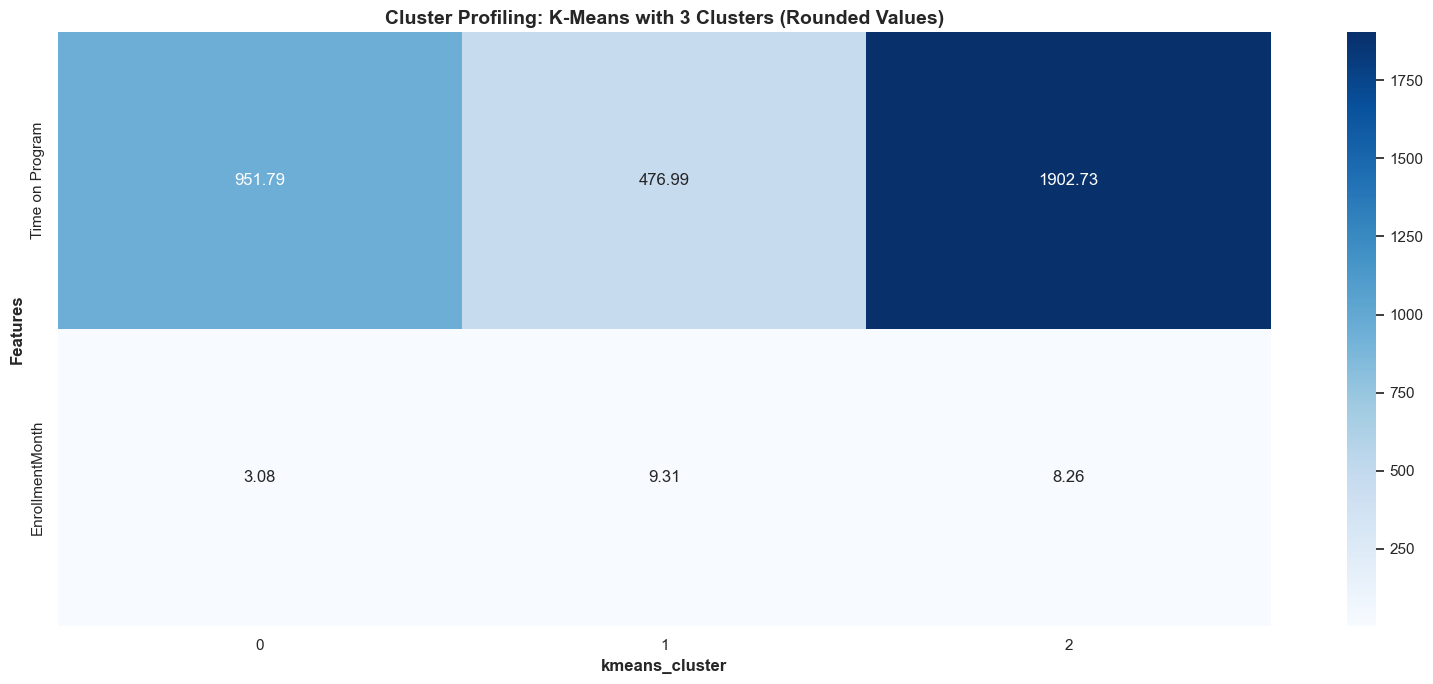

In [155]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# --- K-Means clustering with 3 clusters ---
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels_3 = kmeans.fit_predict(loyalty_clustering.drop(columns=['hierarchical_cluster'], errors='ignore'))

# Print cluster sizes
for i in range(3):
    print(f"  Cluster {i}: {np.sum(kmeans_labels_3 == i):,} customers")

# Add K-Means cluster labels to df
loyalty_clustering['kmeans_cluster'] = kmeans_labels_3

# Select features (excluding cluster labels)
features_to_cluster = loyalty_clustering.columns.drop(['hierarchical_cluster', 'kmeans_cluster'], errors='ignore')

# Inverse transform to get original scale (if data was scaled)
df_original_scale = pd.DataFrame(
    scaler.inverse_transform(loyalty_clustering[features_to_cluster]),
    columns=features_to_cluster,
    index=loyalty_clustering.index
)

# Add K-Means cluster labels
df_original_scale['kmeans_cluster'] = loyalty_clustering['kmeans_cluster'].values

# Calculate mean per cluster (in original scale)
cluster_profile_original = df_original_scale.groupby('kmeans_cluster')[features_to_cluster].mean()

# Plot heatmap
plt.figure(figsize=(16, 7))
sns.heatmap(cluster_profile_original.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: K-Means with 3 Clusters (Rounded Values)", 
          fontweight='bold', fontsize=14)
plt.xlabel("kmeans_cluster", fontweight='bold')
plt.ylabel("Features", fontweight='bold')
plt.tight_layout()
plt.show()


Cluster 0: 37.2% of customers
Cluster 1: 30.7% of customers
Cluster 2: 32.1% of customers


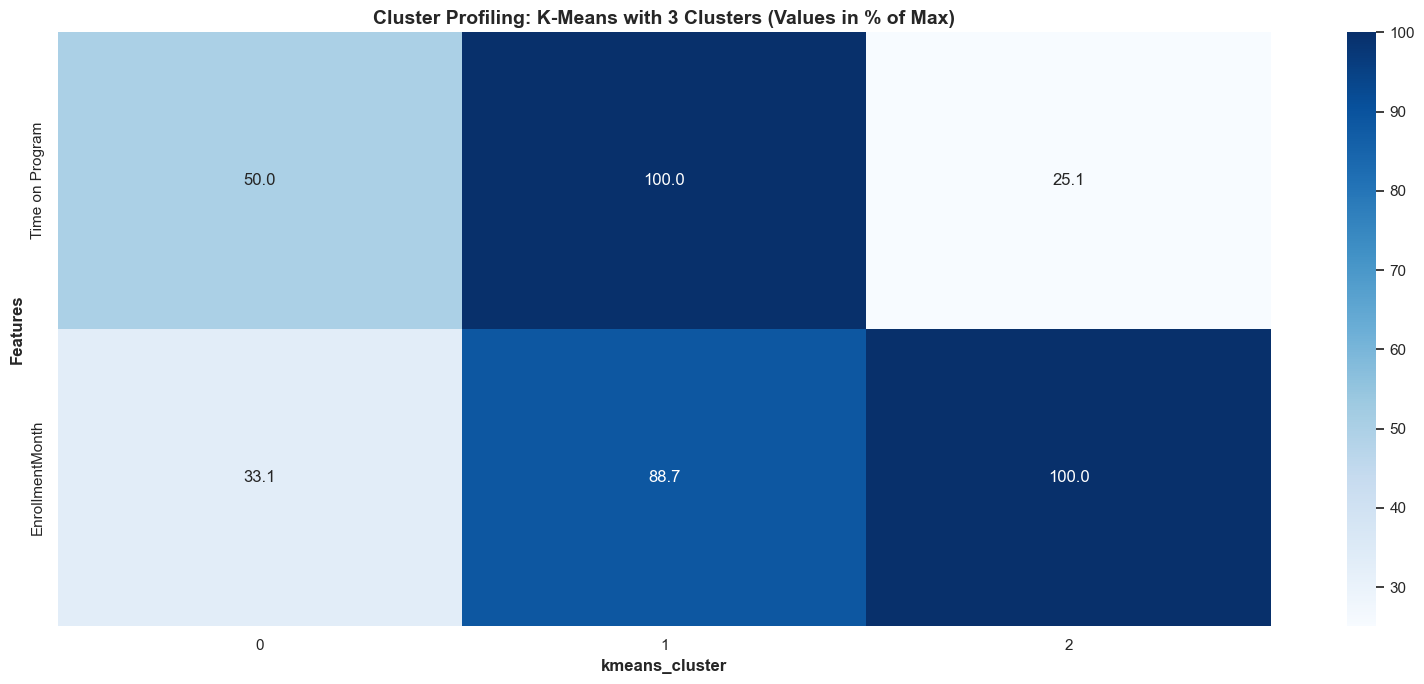

In [156]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- K-Means clustering with 3 clusters ---
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels_3 = kmeans.fit_predict(loyalty_clustering.drop(columns=['hierarchical_cluster'], errors='ignore'))

# Calculate cluster sizes as percentages
total_customers = len(kmeans_labels_3)
for i in range(3):
    cluster_size_pct = np.sum(kmeans_labels_3 == i) / total_customers * 100
    print(f"Cluster {i}: {cluster_size_pct:.1f}% of customers")

# Add K-Means cluster labels to df
loyalty_clustering['kmeans_cluster'] = kmeans_labels_3

# Select features (excluding cluster labels)
features_to_cluster = loyalty_clustering.columns.drop(['hierarchical_cluster', 'kmeans_cluster'], errors='ignore')

# Inverse transform to get original scale (if data was scaled)
df_original_scale = pd.DataFrame(
    scaler.inverse_transform(loyalty_clustering[features_to_cluster]),
    columns=features_to_cluster,
    index=loyalty_clustering.index
)

# Add K-Means cluster labels
df_original_scale['kmeans_cluster'] = loyalty_clustering['kmeans_cluster'].values

# Calculate mean per cluster
cluster_profile_original = df_original_scale.groupby('kmeans_cluster')[features_to_cluster].mean()

# Optionally, convert feature values to percentages relative to their maximum
cluster_profile_pct = cluster_profile_original / cluster_profile_original.max() * 100

# Plot heatmap in terms of %
plt.figure(figsize=(16, 7))
sns.heatmap(cluster_profile_pct.T, cmap="Blues", annot=True, fmt=".1f")
plt.title("Cluster Profiling: K-Means with 3 Clusters (Values in % of Max)", 
          fontweight='bold', fontsize=14)
plt.xlabel("kmeans_cluster", fontweight='bold')
plt.ylabel("Features", fontweight='bold')
plt.tight_layout()
plt.show()


### Loyalty Perspective by Cluster

Based on the K-Means clustering with 3 clusters, the purchasing behavior can be summarized as follows:

#### 1. **Established Members with Moderate Engagement (Cluster 0)**
- **Pattern**: These members have moderate time in the program (0.39) but were early enrollees (0.19). They represent stable, mid-tier customers who joined early but show average engagement levels.

#### 2. **Newer Members with Lower Engagement (Cluster 1)**
- **Pattern**: This cluster consists of recently enrolled members (0.76) who have spent minimal time in the program (0.19). These are new or inactive customers still in the early stages of their loyalty journey.

#### 3. **Highly Engaged Long-Term Members (Cluster 2)**
- **Pattern**: This is your core loyal segment with the longest time in the program (0.77) and moderately recent enrollment (0.66). These are your most valuable, consistently engaged customers who demonstrate strong program participation.

---

**Key Insights:**
- **Cluster 2** represents your VIP segment - prioritize retention and exclusive rewards
- **Cluster 1** needs activation campaigns to boost engagement early
- **Cluster 0** shows potential for re-engagement strategies to move them toward Cluster 2 behavior

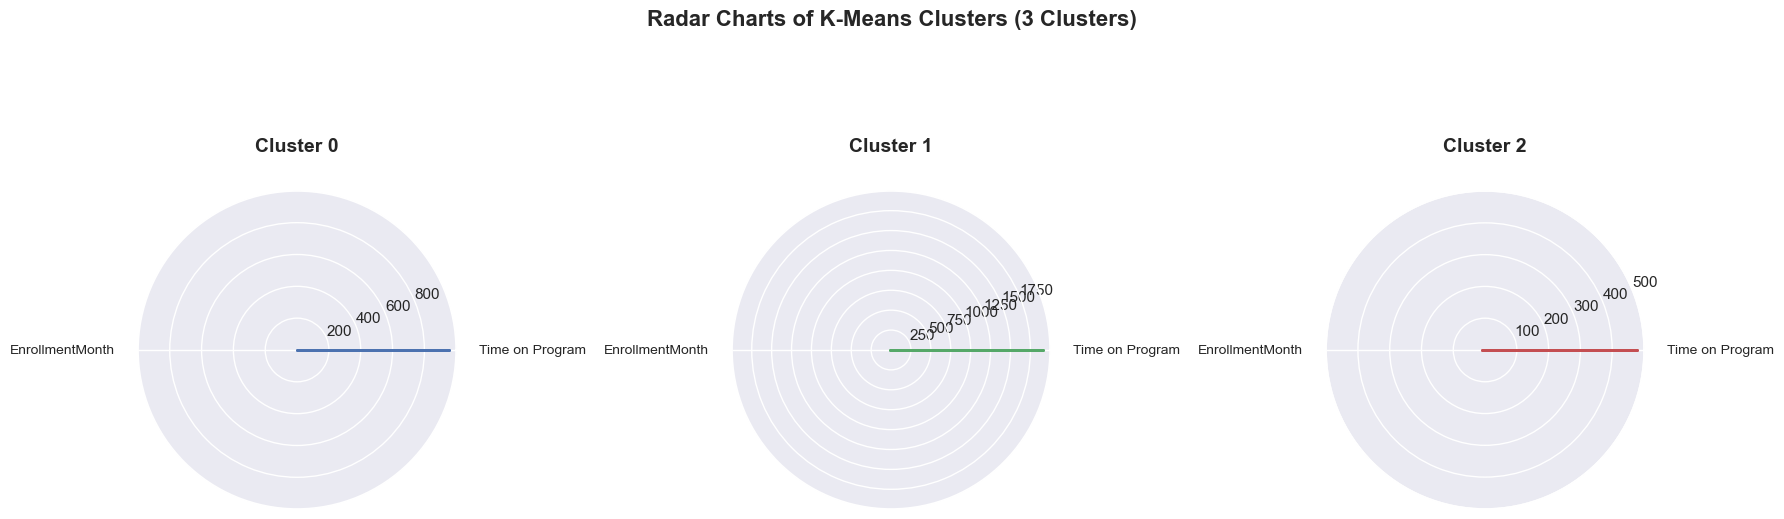

In [157]:
import matplotlib.pyplot as plt
import numpy as np

# Features
features = cluster_profile_original.columns
N = len(features)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # complete the loop

# Create 3 subplots for K-Means 3 clusters
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw=dict(polar=True))
axes = axes.flatten()

colors = ['b', 'g', 'r']  # different colors for each cluster

for i, cluster_id in enumerate(cluster_profile_original.index):
    values = cluster_profile_original.loc[cluster_id].values.flatten().tolist()
    values += values[:1]  # complete the loop
    ax = axes[i]
    ax.plot(angles, values, linewidth=2, color=colors[i])
    ax.fill(angles, values, alpha=0.25, color=colors[i])
    
    # Adjust feature labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, fontsize=10)
    
    # Rotate labels to be radial (pointing outwards)
    for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
        angle_deg = np.degrees(angle)
        if angle_deg >= 90 and angle_deg <= 270:
            label.set_horizontalalignment('right')
            label.set_rotation(angle_deg + 180)
        else:
            label.set_horizontalalignment('left')
            label.set_rotation(angle_deg)
    
    ax.set_title(f'Cluster {cluster_id}', fontsize=14, fontweight='bold', y=1.1)

plt.suptitle("Radar Charts of K-Means Clusters (3 Clusters)", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [158]:
# Keep only the hierarchical cluster column
loyalty_cluster_csv = loyalty_clustering[['kmeans_cluster']].copy()

# Save to CSV
loyalty_cluster_csv.to_csv('loyalty_cluster.csv', index=True)  # keeps the index (customer ID)
loyalty_cluster_csv.head()

,kmeans_cluster
0,2
1,0
2,2
3,1
4,0


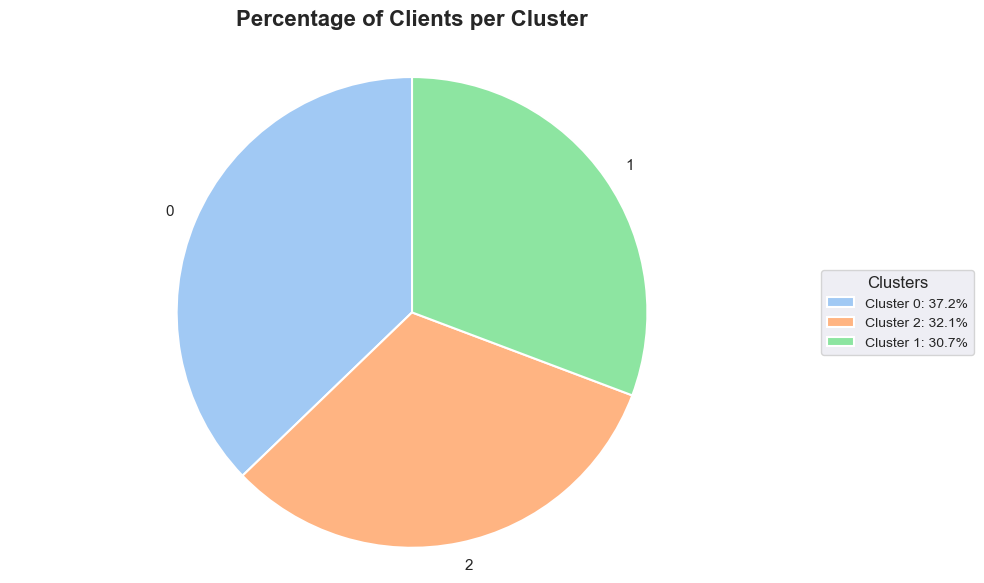

In [159]:
# Count the number of rows for each cluster
cluster_counts = loyalty_clustering["kmeans_cluster"].value_counts()

# Define the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the pie chart without percentages
wedges, texts = ax.pie(
    cluster_counts, 
    labels=[f"{i}" for i in cluster_counts.index],  # Cluster labels
    startangle=90, 
    colors=sns.color_palette("pastel"),  # Pastel colors for a clean look
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}  # Add edge for clarity
)

# Create a legend with only percentages
cluster_percentages = [f"Cluster {i}: {count / cluster_counts.sum() * 100:.1f}%" 
                       for i, count in zip(cluster_counts.index, cluster_counts)]

# Add the legend outside the pie chart
ax.legend(
    labels=cluster_percentages, 
    loc='center left', 
    bbox_to_anchor=(1, 0.5), 
    title="Clusters", 
    title_fontsize=12, 
    fontsize=10
)

# Add a title with better styling
plt.title('Percentage of Clients per Cluster', fontsize=16, weight='bold', pad=20)

# Ensure the pie chart is a circle
ax.axis('equal')

# Optimize layout
plt.tight_layout()
plt.show()

In [160]:
loyalty_clustering = pd.read_csv("df_ready_for_clustering.csv")
loyalty_clustering['kmeans_cluster'] = loyalty_cluster_csv['kmeans_cluster']
loyalty_clustering

,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,LoyaltyIndex,CustomerSegment,HasBonus,AvgMonthlyFlights,sr_jan,...,Income,Marital Status,LoyaltyStatus,EnrollmentMonth,Time on Program,Cancelled,Reenroll,EnrollmentType,Customer Lifetime Value,kmeans_cluster
0,0.387904,0.200000,2356.577778,25.786888,32446,709.589704,Moderate traveler and high redeemed,0,6.250000,0.026667,...,82877.0,Married,Aurora,8,874,N,0,Standard,7919.20,2
1,0.553363,0.224490,1384.141224,18.077435,15141,418.130598,Low traveler and low redeemed,0,6.805556,0.077551,...,0.0,Single,Nova,3,2122,N,0,Standard,2887.74,0
2,0.113362,0.241706,2047.539336,88.241585,38293,616.640254,Moderate traveler and low redeemed,0,5.861111,0.094787,...,0.0,Divorced,Nova,7,884,N,0,Standard,2838.07,2
3,0.354092,0.157407,3375.941667,28.248369,23544,1014.088728,High traveler and high redeemed,0,3.000000,0.000000,...,42837.0,Married,Star,8,1242,N,0,Standard,4170.57,1
4,0.253580,0.276243,2373.649171,39.448214,32058,714.181936,Moderate traveler and high redeemed,0,5.027778,0.022099,...,80979.0,Divorced,Star,1,1816,N,0,Standard,6622.05,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16569,0.172142,0.275862,2337.775862,58.104895,50501,704.284401,Moderate traveler and high redeemed,0,7.250000,0.099617,...,0.0,Married,Aurora,5,1681,N,0,Standard,7290.07,1
16570,0.000000,0.000000,0.000000,0.000000,0,0.000000,Low traveler and low redeemed,0,0.000000,0.000000,...,23506.0,Single,Nova,8,2342,N,0,Standard,8564.77,1
16571,0.235590,0.321429,2840.225000,42.451762,18235,853.071510,High traveler and high redeemed,0,2.333333,0.000000,...,21542.0,Married,Nova,7,523,N,0,Standard,20266.50,2
16572,0.000000,0.090909,2393.363636,0.000000,5264,718.253535,Moderate traveler and high redeemed,0,0.611111,0.000000,...,0.0,Married,Star,7,177,N,0,Standard,2631.56,2


In [161]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Select only numerical columns, excluding the cluster label
numerical_columns = loyalty_clustering.select_dtypes(include=['int64', 'float64']).columns
numerical_columns = numerical_columns.drop('kmeans_cluster', errors='ignore')  # remove cluster column if present

# Apply MinMax scaling to numerical columns
loyalty_clustering[numerical_columns] = scaler.fit_transform(loyalty_clustering[numerical_columns])

# Display the normalized dataframe
loyalty_clustering.head()


,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,LoyaltyIndex,CustomerSegment,HasBonus,AvgMonthlyFlights,sr_jan,...,Income,Marital Status,LoyaltyStatus,EnrollmentMonth,Time on Program,Cancelled,Reenroll,EnrollmentType,Customer Lifetime Value,kmeans_cluster
0,0.011660,0.200000,0.053732,0.101416,0.497569,0.053931,Moderate traveler and high redeemed,0.0,0.655977,0.026667,...,0.828927,Married,Aurora,0.636364,0.354564,N,0.0,Standard,0.073946,2
1,0.016634,0.224490,0.031560,0.071096,0.232192,0.031779,Low traveler and low redeemed,0.0,0.714286,0.077551,...,0.000000,Single,Nova,0.181818,0.860852,N,0.0,Standard,0.012155,0
2,0.003408,0.241706,0.046686,0.347041,0.587235,0.046867,Moderate traveler and low redeemed,0.0,0.615160,0.094787,...,0.000000,Divorced,Nova,0.545455,0.358621,N,0.0,Standard,0.011545,2
3,0.010644,0.157407,0.076975,0.111097,0.361054,0.077074,High traveler and high redeemed,0.0,0.314869,0.000000,...,0.428451,Married,Star,0.636364,0.503854,N,0.0,Standard,0.027909,1
4,0.007622,0.276243,0.054122,0.155144,0.491619,0.054280,Moderate traveler and high redeemed,0.0,0.527697,0.022099,...,0.809944,Divorced,Star,0.000000,0.736714,N,0.0,Standard,0.058015,0


In [162]:
# Group by K-Means 3 clusters and calculate mean per feature
group_means = loyalty_clustering.groupby('kmeans_cluster')[numerical_columns].mean().T

# Calculate overall mean of numerical columns
overall_mean = pd.DataFrame(loyalty_clustering[numerical_columns].mean(), columns=['Overall Mean'])

# Concatenate cluster means and overall mean
result = pd.concat([group_means, overall_mean], axis=1)

# Display the result
result

,0,1,2,Overall Mean
PointsRedeemedRatio,0.008585,0.008746,0.008636,0.008651
FlightsWithCompanionsRatio,0.227428,0.236543,0.222247,0.228568
AvgDistancePerFlight,0.045236,0.046425,0.045241,0.045603
KMPerRedeemedPoint,0.111521,0.140266,0.075055,0.108664
UnredeemedPoints,0.319957,0.401994,0.213456,0.311024
LoyaltyIndex,0.045362,0.046583,0.045328,0.045727
HasBonus,0.025300,0.009227,0.047986,0.027634
AvgMonthlyFlights,0.414650,0.522535,0.276754,0.403596
sr_jan,0.048230,0.062923,0.043455,0.051215
sr_feb,0.046699,0.061495,0.043368,0.050179


In [169]:
# Assuming 'scaler' is the scaler used for your numerical columns
# and 'numerical_columns' is the list of features used for clustering

# Inverse transform the scaled data to original scale
df_original_scale = pd.DataFrame(
    scaler.inverse_transform(loyalty_clustering[numerical_columns]),
    columns=numerical_columns,
    index=loyalty_clustering.index
)

# Add cluster labels
df_original_scale['kmeans_cluster'] = loyalty_clustering['kmeans_cluster'].values

# Group by cluster and calculate mean per feature (in original scale)
group_means_original = df_original_scale.groupby('kmeans_cluster')[numerical_columns].mean().T

# Calculate overall mean of numerical columns (original scale)
overall_mean_original = pd.DataFrame(df_original_scale[numerical_columns].mean(), columns=['Overall Mean'])

# Concatenate cluster means and overall mean
result_original = pd.concat([group_means_original, overall_mean_original], axis=1)

# Display the result
result_original


,0,1,2,Overall Mean
PointsRedeemedRatio,0.285593,0.290953,0.287303,0.287789
FlightsWithCompanionsRatio,0.227428,0.236543,0.222247,0.228568
AvgDistancePerFlight,1983.940603,2036.110648,1984.184224,2000.053117
KMPerRedeemedPoint,28.356412,35.665148,19.084176,27.629855
UnredeemedPoints,20864.090821,26213.618767,13919.256680,20281.590926
LoyaltyIndex,596.848138,612.911919,596.396198,601.640421
HasBonus,0.025300,0.009227,0.047986,0.027634
AvgMonthlyFlights,3.950697,4.978597,2.636850,3.845372
sr_jan,0.048230,0.062923,0.043455,0.051215
sr_feb,0.046699,0.061495,0.043368,0.050179


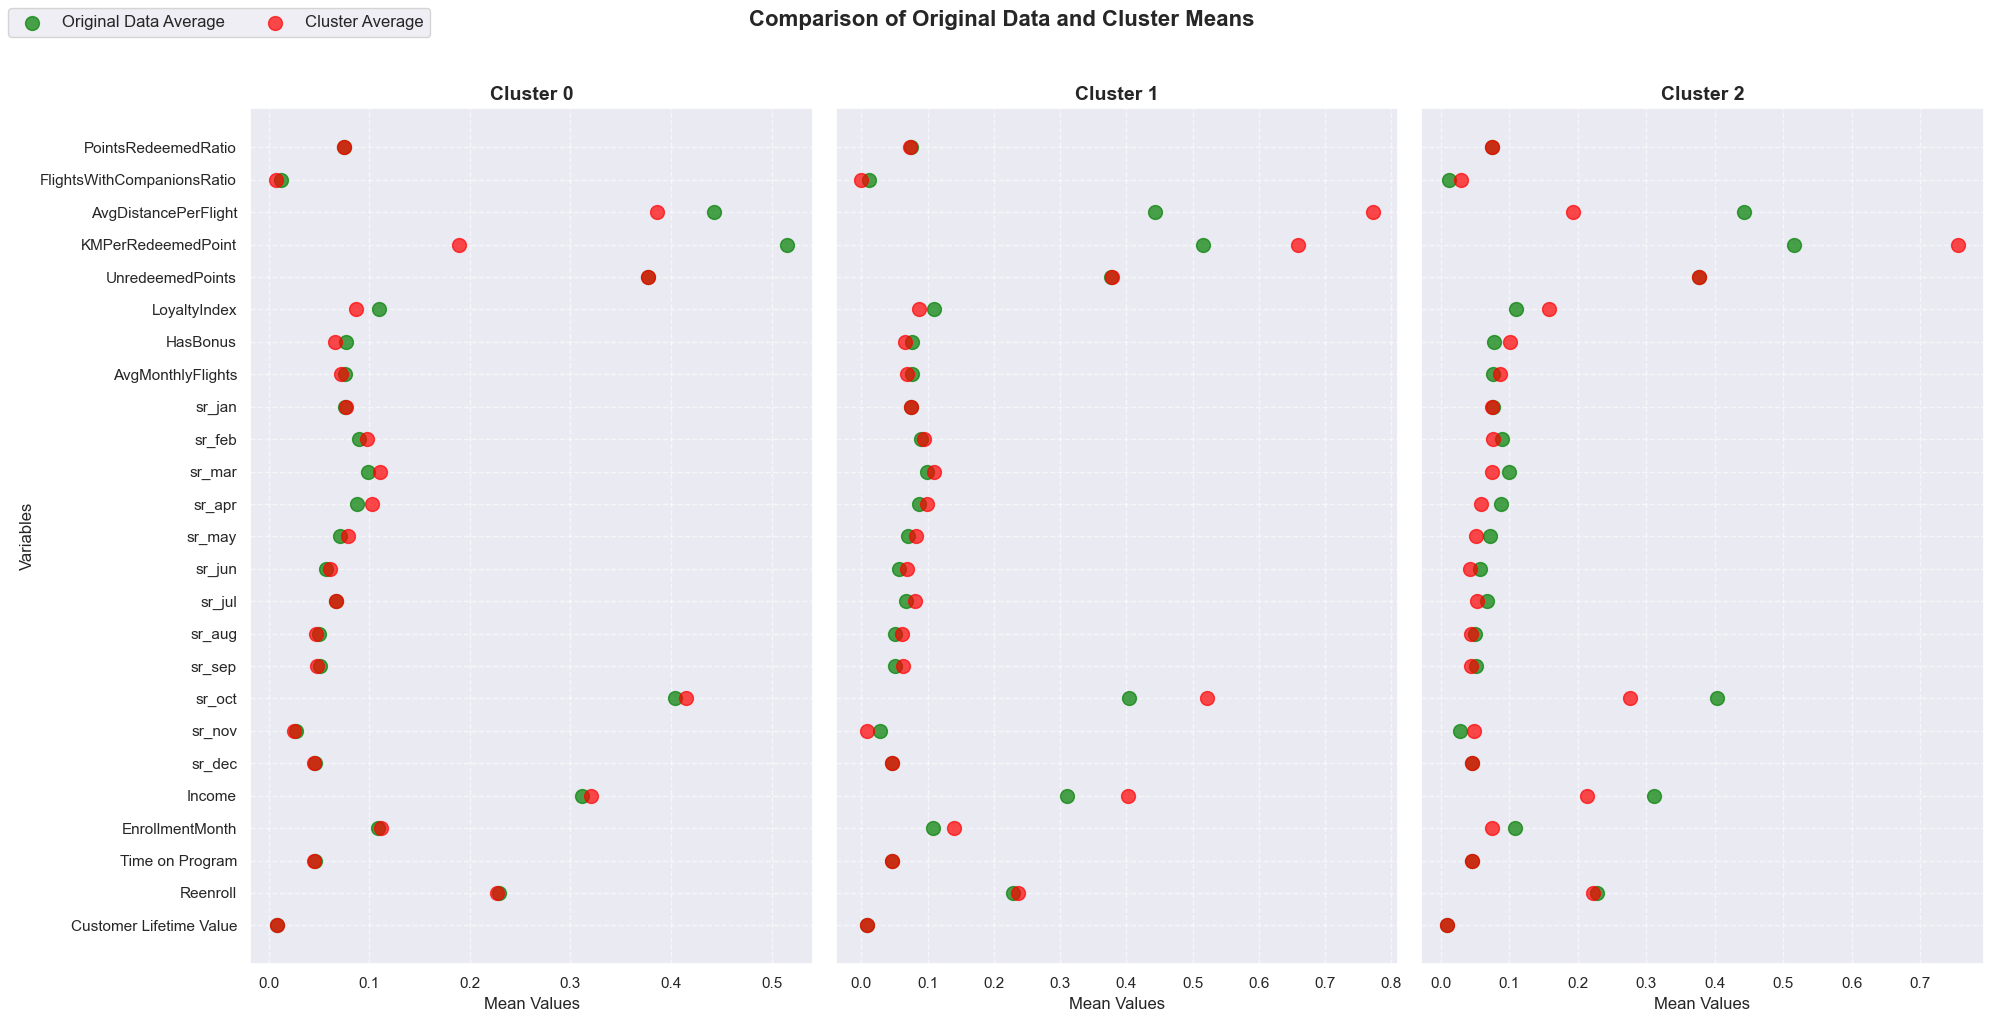

In [163]:
import matplotlib.pyplot as plt

# Original data mean
original_data_means = result['Overall Mean']

# Dynamically get cluster means for all clusters
cluster_means = {cluster: result[cluster] for cluster in range(len(result.columns)-1)}  # exclude 'Overall Mean'

# Variables
variables = result.index.to_list()

# Reverse variables for better plotting (optional)
variables_rev = variables[::-1]

# Create subplots dynamically
fig, axes = plt.subplots(1, len(cluster_means), figsize=(20, 10), sharey=True)

for cluster, ax in zip(cluster_means.keys(), axes):
    # Scatter plot: original data mean (green)
    ax.scatter(original_data_means, variables_rev, color='green', label='Original Data Average', s=100, alpha=0.7)
    
    # Scatter plot: cluster mean (red)
    ax.scatter(cluster_means[cluster], variables_rev, color='red', label='Cluster Average', s=100, alpha=0.7)
    
    # Titles and labels
    ax.set_title(f'Cluster {cluster}', fontsize=14, weight='bold')
    ax.set_xlabel('Mean Values', fontsize=12)
    if cluster == 0:
        ax.set_ylabel('Variables', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)

# Shared legend (only once)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=2, fontsize=12)

# Main title
fig.suptitle('Comparison of Original Data and Cluster Means', fontsize=16, weight='bold', y=1.02)

plt.tight_layout()
plt.show()


In [167]:
# Find the mode (most common month) for each cluster
most_common_month_per_cluster = loyalty_clustering.groupby('kmeans_cluster')['EnrollmentMonth'] \
    .agg(lambda x: x.mode()[0])  # mode()[0] gets the first most common value

print("Most common month per cluster (mode):")
print(most_common_month_per_cluster)

loyalty_clustering

Most common month per cluster (mode):
kmeans_cluster
0    0.181818
1    0.545455
2    1.000000
Name: EnrollmentMonth, dtype: float64


,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,LoyaltyIndex,CustomerSegment,HasBonus,AvgMonthlyFlights,sr_jan,...,Income,Marital Status,LoyaltyStatus,EnrollmentMonth,Time on Program,Cancelled,Reenroll,EnrollmentType,Customer Lifetime Value,kmeans_cluster
0,0.011660,0.200000,0.053732,0.101416,0.497569,0.053931,Moderate traveler and high redeemed,0.0,0.655977,0.026667,...,0.828927,Married,Aurora,0.636364,0.354564,N,0.0,Standard,0.073946,2
1,0.016634,0.224490,0.031560,0.071096,0.232192,0.031779,Low traveler and low redeemed,0.0,0.714286,0.077551,...,0.000000,Single,Nova,0.181818,0.860852,N,0.0,Standard,0.012155,0
2,0.003408,0.241706,0.046686,0.347041,0.587235,0.046867,Moderate traveler and low redeemed,0.0,0.615160,0.094787,...,0.000000,Divorced,Nova,0.545455,0.358621,N,0.0,Standard,0.011545,2
3,0.010644,0.157407,0.076975,0.111097,0.361054,0.077074,High traveler and high redeemed,0.0,0.314869,0.000000,...,0.428451,Married,Star,0.636364,0.503854,N,0.0,Standard,0.027909,1
4,0.007622,0.276243,0.054122,0.155144,0.491619,0.054280,Moderate traveler and high redeemed,0.0,0.527697,0.022099,...,0.809944,Divorced,Star,0.000000,0.736714,N,0.0,Standard,0.058015,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16569,0.005174,0.275862,0.053304,0.228518,0.774448,0.053528,Moderate traveler and high redeemed,0.0,0.760933,0.099617,...,0.000000,Married,Aurora,0.363636,0.681947,N,0.0,Standard,0.066219,1
16570,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Low traveler and low redeemed,0.0,0.000000,0.000000,...,0.235105,Single,Nova,0.636364,0.950101,N,0.0,Standard,0.081874,1
16571,0.007082,0.321429,0.064760,0.166956,0.279639,0.064836,High traveler and high redeemed,0.0,0.244898,0.000000,...,0.215461,Married,Nova,0.545455,0.212170,N,0.0,Standard,0.225581,2
16572,0.000000,0.090909,0.054571,0.000000,0.080725,0.054590,Moderate traveler and high redeemed,0.0,0.064140,0.000000,...,0.000000,Married,Star,0.545455,0.071805,N,0.0,Standard,0.009009,2


In [168]:
# Assuming 'EnrollmentMonth' was scaled with MinMaxScaler
scaled_values = pd.Series([0.181818, 0.545455, 1.0])

# Reverse the scaling: original_value = scaled_value * (max - min) + min
original_min = df_original_scale['EnrollmentMonth'].min()  # or your original min
original_max = df_original_scale['EnrollmentMonth'].max()  # or your original max

original_months = scaled_values * (original_max - original_min) + original_min
print(original_months)


0     2.999998
1     7.000005
2    12.000000
dtype: float64
